<a href="https://colab.research.google.com/github/ThomasHoek/AI-AS/blob/master/Deep_Q_Learning_Thomas_Alter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning project - Deep Q-Learning


## Aim
Time to up our [OpenAI Gym](https://gym.openai.com/) game with some [Atari Space Invaders](https://gym.openai.com/envs/SpaceInvaders-v0/) (or another [supported Atari game](https://gym.openai.com/envs/#atari)!). Q-Learning won't cut it this time. Let's take out the DQNs and beat this game!

## Runtime and environment
This [Jupyter Notebook](https://jupyterlab.readthedocs.io/en/latest/) was made to run on Google Colab. For this training, we recommend using the Google Colab environment.

Please read the [instructions on Google Colab](https://medium.com/swlh/the-best-place-to-get-started-with-ai-google-colab-tutorial-for-beginners-715e64bb603b) to get started quickly. It behaves similar to Jupyter Notebook, Jupyter Hub and Jupyter Lab, so if you have any experience with those, you're good to go!

Some notes on Google Colab:
- **Processes in Google Colab won't run forever**. These may be terminated at any time when the platform is crowded, and *will definitely* terminate after 12 hours. To maintain persistency, you can attach the session to **Google Drive** and have your models persist themselves to the Google Drive periodically.
- You can enable GPU or TPU support! You can find this option under *Runtime* -> *Change runtime type*.
- After installing dependencies, you need to restart the runtime in order to actually use them.

If you want to run the code on your own platform or system, you need to keep a few things in mind:
- The dependencies you need to install may differ from the ones we installed here. The installed dependencies are suitable for Google Colab, Ubuntu, and Debian.
- Since Google Colab isn't attached to a monitor, we render the output to a video file. On your own machine the built-in render method from OpenAI's Gym may suffice.
- The default paths use Google Drive! Change these.

## Info Support
This assignment was developed by Info Support. Looking for a graduation project or job? Check out their website: https://carriere.infosupport.com/




# Preparation

Some dependencies need to be installed for the code to work. Furthermore, we will define some methods which allow us to show the OpenAI Gym renderings in this (headless) Google Colab environment.

In [ ]:
# Install dependencies
"""Note: if you are running this code on your own machine, you probably don't need all of these.
   Start with 'pip install gym' and install more packages if you run into errors."""
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg cmake > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install atari-py > /dev/null 2>&1
!pip install torchagent > /dev/null 2>&1
!pip install celluloid > /dev/null 2>&1

# New requirement!
!pip install colabgymrender

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)


In [ ]:
# Imports for helper functions
import base64
import copy
import io
import math
from pathlib import Path

import gym
import matplotlib
import matplotlib.pyplot as plt
from colabgymrender.recorder import Recorder        # New import!!
from google.colab import drive
from gym.wrappers import Monitor
from IPython import display as ipythondisplay
from IPython.display import HTML
from pyvirtualdisplay import Display

In [ ]:
%%shell

wget -O Roms.rar http://www.atarimania.com/roms/Roms.rar
unrar e Roms.rar
python -m atari_py.import_roms ./ > /dev/null 2>&1

--2021-06-01 07:51:36--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   477KB/s    in 24s     

2021-06-01 07:52:00 (460 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK


In [ ]:
# Mount your Google Drive. By doing so, you can store any output, models, videos, and images persistently.

# Note: in this new version of the notebook, we no longer render video's to Google Drive, but to a temporary storage within the container!
# Please copy files from /tmp/HU_RL/ to /content/gdrive/My Drive/<my_path> that you want to keep, or just download them through the viewer!

enable_gdrive = False   # Switch to indicate whether Google Drive should be mounted.

if enable_gdrive:
    drive.mount('/content/gdrive')

In [ ]:
# Create a directory to store the data for this lab. Feel free to change this.
if enable_gdrive:
    drive_path = Path('/content/gdrive/My Drive/Colab Notebooks/HU_RL/part1')
    drive_path.mkdir(parents=True, exist_ok=True)

tmp_path_on_container = Path('/tmp/HU_RL/')
video_path = tmp_path_on_container / 'video'
video_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# Define helper functions to visually show what the models are doing.
%matplotlib inline

gym.logger.set_level(gym.logger.ERROR)

display = Display(visible=0, size=(1400, 900))
display.start()

# def show_video():
#     # Display the stored video file
#     # Credits: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/
#     mp4list = list(data_path.glob('video/*.mp4'))
#     if len(mp4list) > 0:
#         mp4 = mp4list[-1]
#         video = io.open(mp4, 'r+b').read()
#         encoded = base64.b64encode(video)
#         ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
#                 loop controls style="height: 400px;">
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#             </video>'''.format(encoded.decode('ascii'))))
#     else: 
#         print('Could not find video')

# def record_episode(idx):
#     # This determines which episodes to record.
#     # Since the video rendering in the OpenAI Gym is a bit buggy, we simply override it and decide
#     # whether or not to render inside of our training loop.
#     return True

def video_env(env):
    # Wraps the environment to write its output to a video file
    # env = Monitor(env, video_path, video_callable=record_episode, force=True)
    env = Recorder(env, video_path, 15)     # Render at 15 FPS. Try to keep this low, to prevent hitting quotas.
    return env

# Test the environment

In [ ]:
"""Let's check out the Space Invaders environment"""
from PIL import Image as pil_Image
from IPython.display import Image

from celluloid import Camera # getting the camera



import os
# Create the desired environment
env = gym.make("SpaceInvaders-v0")

# Wrap the environment, to make sure we get to see a fancy video
env = video_env(env)

# Before you can use a Gym environment, it needs to be reset.
state = env.reset()

# Perform random actions untill we lose (or win).
done = False
images = []
while not done:
    env.render()
    # What the AI sees
    img = state[18:195,10:150]
    img = img[::4, ::2]
    # img = img.mean(axis=2)
    # Next we normalize the image from -1 to +1
    # img = (img - 128) / 128 - 1
    frame = pil_Image.fromarray(img, 'RGB')
    images.append(frame)
    # The action_space contains all possible actions we can take.
    random_action = env.action_space.sample()
    state, reward, done, info = env.step(random_action)



# Show the results!
env.play()  # Render the video

images[0].save('pillow_imagedraw.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=45, loop=0)


# So... this works exactly the same as with the previous environments! The only differences are the state space and possible actions.

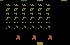

In [ ]:
Image(open('pillow_imagedraw.gif','rb').read(), width=400, height=400)

In [ ]:
# Check out the new state:
print('State shape:', state.shape)

# We have 210 rows, each 160 pixels wide, and each pixel having an RGB value.
# The range of each pixel is 0-255

#print('State:', state)
print(env.action_space.n)

State shape: (210, 160, 3)
6


# Setup


In [ ]:
# Imports
import random
from itertools import count

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchagent.memory import SequentialMemory, Transition
from torchagent.policy import DecayingEpsilonGreedyPolicy, EpsilonGreedyPolicy, GreedyPolicy

In [ ]:
# Setup GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Wrappers

In [ ]:
def observation(observation):
    # Crop the image
    img = observation[18:195,10:150]
    img = img[::4, ::2]
    # Convert the image to greyscale
    img = img.mean(axis=2)
    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    # print(img.shape + (1,))
    return img.reshape(img.shape + (1,))

class ResizeWrapper(gym.ObservationWrapper):
    # This wrapper resizes and normalizes the input images.
    # Feel free to update it! :-)

    def __init__(self, env):
        super(ResizeWrapper, self).__init__(env)
    
    def observation(self, observation):
        # Crop the image
        img = observation[18:195,10:150]
        img = img[::4, ::2]
        # Convert the image to greyscale
        img = img.mean(axis=2)
        # Next we normalize the image from -1 to +1
        img = (img - 128) / 128 - 1

        #print(img.shape + (1,))
        return img.reshape(img.shape + (1,))

class TorchWrapper(gym.ObservationWrapper):
    # You don't need to worry about this block of code. It should just work.
    def __init__(self, env):
        super(TorchWrapper, self).__init__(env)

    def observation(self, observation):
        output = np.rollaxis(observation, 2, 0)
        output = output.reshape(-1, output.shape[0], output.shape[1], output.shape[2]).astype(np.float32)

        return torch.from_numpy(output).to(device)


# Environment creation

In [ ]:
def create_environment(name='SpaceInvaders-v0'):
    # A shorthand to create a new environment with all of the required wrappers
    env = gym.make(name)
    env = ResizeWrapper(env)
    env = TorchWrapper(env)
    env = video_env(env)
    return env

# DQN Agent

In [ ]:
class SequentialMemory(SequentialMemory):

    def get_state(self, numbers):
        state_lst = []
        for number in numbers:
            state_lst.append(torch.cat((self.data[number].state,
                                         self.data[number - 1].state,
                                         self.data[number - 2].state,
                                         self.data[number - 3].state),0))
        return state_lst

    def get_next_state(self, numbers):
        state_lst = []
        for number in numbers:
            state_lst.append(torch.cat((self.data[number].next_state,
                                         self.data[number - 1].next_state,
                                         self.data[number - 2].next_state,
                                         self.data[number - 3].next_state),0))
        return state_lst

    def bulk_sample(self, batch_size=1):
        """
        Samples transitions from the replay memory

        Parameters:
            batch_size (int): The number of samples to retrieve

        Returns:
            array: The array of sampled entries
        """
        # print(self.data[0], batch_size)
        if len(self.data) < batch_size:
            raise AssertionError('There are not enough samples available')

        return_lst = []
        if (len(self.data) - 3) < batch_size:
            bulk_numbers = random.sample(list(range(len(self.data) - 3)), batch_size - 3)
        else:
            bulk_numbers = random.sample(list(range(len(self.data) - 3)), batch_size)
        return [self.data[i + 3] for i in bulk_numbers], [i + 3 for i in bulk_numbers]

In [ ]:
class DQNAgent:
    """
    An implementation of an agent that uses Deep Q-Learning.

    It uses the DQN class, defined further down below, to make decisions for its next move.
    """

    def __init__(self, num_actions, model, loss, optimizer,
                 memory, policy=None, test_policy=None,
                 training=True, enable_dqn=False, batch_size=32,
                 gamma=0.9, tau=1e-3, warmup_steps=0, update_steps=4):
        """
        Initializes a new instance of a Deep Q-Learning agent.
        Parameters:
            num_actions (int): The number of actions that is supported
            model (object): The neural network that is used to calculate the q-values for the agent
            loss (object): The loss function to use for optimizing the agent
            optimizer (object): The optimizer to use for optimizing the agent
            memory (object): The experience buffer to use for the agent
            policy (object): The policy network to use for the agent
            test_policy (object): The target policy network to use for the agent
            training (boolean): Flag indicating the agent is training
            enable_dqn (boolean): Flag enabling double-q value learning
            batch_size (int): The number of samples to use for each cycle of training
            gamma (float): The discount factor for rewards the agent receives
            tau (float): Factor controlling the speed at which the target model is updated
            warmup_steps (int): The number of warmup steps before starting to update the target network
        """

        self.policy = policy if policy is not None else EpsilonGreedyPolicy(num_actions)
        self.test_policy = test_policy if test_policy is not None else GreedyPolicy(num_actions)
        self.memory = memory
        self.training = training
        self.batch_size = batch_size
        self.model = model
        self.target_model = copy.deepcopy(model)
        self.enable_dqn = enable_dqn
        self.num_actions = num_actions
        self.loss = loss
        self.gamma = gamma
        self.optimizer = optimizer
        self.tau = tau
        self.step = 0
        self.warmup_steps = warmup_steps
        self.update_steps = update_steps



    def record(self, state, action, next_state, reward, done):
        """
        Records experience for the agent
        Parameters:
            state (object): The current state
            action (object): The action that was performed
            next_state (object): The next state
            reward (object): The received reward
            done (boolean): Flag indicating the episode was completed
        """
        self.memory.append(state, action, next_state, reward, done)

    def act(self, observation):
        """
        Allows the agent to perform a step based on the provided observation of the environment.
        Parameters:
            observation (object): The observation for the agent to base its decision on.
        Returns:
            int: The index of the selected action
        """

        # First, calculate the q-values for the action space that the agent supports
        # Next, use the training or test policy to predict the next action to take
        
        with torch.no_grad():
            test = torch.cat((observation,observation,observation,observation), 0)
            action_tensor = self.model(torch.reshape(test, [1,1,180,70]))
            # action_tensor = self.model(observation)

        if self.training:
            selected_action = self.policy.select_action(action_tensor, step=self.step)
        else:
            selected_action = self.test_policy.select_action(action_tensor, step=self.step)

        return selected_action

    def train(self):
        """
        Performs a single training pass using the agent's memory as input.
        """
        if len(self.memory) < self.batch_size:
            return

        batch, numbers = self.memory.bulk_sample(self.batch_size)
        # print(len(batch), batch)
        # 10 / 0
        batch = Transition(*zip(*batch))

        self.step += 1

        self.train_model_(batch, numbers)
        self.update_target_model_()


    def train_model_(self, batch, numbers):
        if self.step < self.warmup_steps or self.step % self.update_steps > 0:
            return
    
        # state_batch2 = torch.cat(batch.state)
        state_batch = torch.cat(self.memory.get_state(numbers))
        action_batch = torch.cat(batch.action)
        
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(self.memory.get_next_state(numbers))
        terminated_batch = torch.tensor(
            [1. if s == False else 0. for s in batch.done], device=device, dtype=torch.float)
        
        # print(state_batch.size(), state_batch2.size(), action_batch.size())
        # We're trying to minimize a loss that is defined as follows:
        # loss = sum(sqr(reward + gamma * target_Q(next_state) - Q(state)))
        #
        # Please note that you can use the huber loss also, but it uses the same inputs:
        # - Q(next_state, a) --> Q-values for the target state
        # - Q(state, a) --> Q-values for the current state
        #
        # We're using a second network to calculate the Q-values for the target state.
        # this stabalizes the training process so it becomes more predictable.
        # state_batch = self.model(torch.reshape(state_batch, [1,1,180,70]))
        # next_state_batch = self.model(torch.reshape(next_state_batch, [1,1,180,70]))
        
        q_values =  self.model(torch.reshape(state_batch, [self.batch_size,1,180,70]))  # (N, 6) Q-table
        target_q_values = self.target_model(torch.reshape(next_state_batch, [self.batch_size,1,180,70])) # (N, 6) Q-table
        q_values = q_values.gather(1, action_batch)  # (N, 1) Q-values of current state

        if not self.enable_dqn:
            target_q_values = target_q_values.gather(1, action_batch)  # (N, 1) expected Q-values based on current action
        else:
            estimated_actions = q_values.max(1)[1].unsqueeze(1)  # Action selection on training network
            target_q_values = target_q_values.gather(1, estimated_actions)  # Action evaluation on target network
        
        # Calculate the discounted award for the actions taken by the agent.
        # Then reset the reward for the actions that caused the episode to end.
        discounted_reward = self.gamma * target_q_values
        discounted_reward = terminated_batch * discounted_reward

        # Calculate the expected reward using the discounted reward and the actual reward.
        targets = discounted_reward + reward_batch
        targets = targets.detach()

        loss_value = self.loss(q_values, targets.unsqueeze(1))

        # Finally, optimize the policy using the choosen optimizer.
        self.optimizer.zero_grad()
        loss_value.backward()

        for param in self.model.parameters():
            param.grad.data.clamp(-1, 1)

        self.optimizer.step()

    def update_target_model_(self):
        if self.step < self.warmup_steps:
            return

        if self.tau < 1.:
            for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - self.tau) +
                    param.data * self.tau   # This line was updated!
                )
        else:
            if self.step % self.tau == 0:
                self.target_model.load_state_dict(self.model.state_dict())

# DQN - Network to estimate Q-values

In [ ]:
class DQN(nn.Module):
    """ 
    This is the network used by the agent to take a decision on its next action.
    """
    def __init__(self, h, w, channels, outputs):
        """
        Initializes a new instance of DQN
        Parameters:
            h (int): The height of the input screen
            w (int): The width of the input screen
            channels (int): The number of channels in the input screen
            outputs (int): The number of actions to choose from
        """
        super(DQN, self).__init__()

        def conv_output_size(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        print(h,w)
        # Each conv2D layer resizes the input as calculated in the formula above.
        # Since we're stacking layers, we need to stack the output size calculation as well.
        features_w = conv_output_size(conv_output_size(conv_output_size(w, 8, 4), 4, 2), 3, 1)
        features_h = conv_output_size(conv_output_size(conv_output_size(h, 8, 4), 4, 2), 3, 1)

        self.conv1 = nn.Conv2d(channels, 16, 8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2)
        self.conv3 = nn.Conv2d(32, 16, 3, stride=1)
        self.fc = nn.Linear(features_w*features_h*16, 64)
        self.output = nn.Linear(64, outputs)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        """
        Performs the forward pass through the neural network
        Parameters:
            x (tensor): The input tensor for the policy network
        """
        y = self.relu1(self.conv1(x))
        y = self.relu2(self.conv2(y))
        y = self.relu3(self.conv3(y))
        
        # Flatten the output of the convolutional layer.
        # This is required to match the shape with the linear layer.
        y = y.view(y.size(0), -1)

        y = self.relu4(self.fc(y))
        y = self.output(y)

        return y

# Training

Here we start the actual training process.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

env = create_environment()
#model = DQN(80, 105, 1, env.action_space.n).to(device)
frames_amount = 4
model = DQN(45 * frames_amount, 70 , 1, env.action_space.n).to(device)  # Don't forget to update these values after resizing or normalizing the images!

loss = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.00025)
memory = SequentialMemory(1000000)

num_episodes = 1000
num_episodes_between_videos = 50
num_episodes_between_print = 5

# Define an agent that uses the experience buffer and value-function model that we created before.
# The agent will try to optimize the value-function to estimate the value of each possible state/action pair.
#
# The agent uses a decaying epsilon-greedy policy to determine the action to execute in the environment.
# We're moving from 100% random to 0.1% chance of random actions in 1M steps. 
# This means, we'll be totally random at the start and slowly moving towards a deterministic policy.
# 
# Note on the gamma parameter: this controls the discount of future rewards when it comes to estimating
# the value-function. A reward received from the current action accounts for 100% of the value of an action
# in the current state. Any possible action in the next state only contributes 99% of its reward towards the
# value in the current state!
# 
# Note on the tau parameter: this controls the speed at which we update the value-function network in the agent.
# We're using a pair of neural networks in the agent to help with the optimization process for the value-function.
# Setting a tau value larger than 1 means that the target network only gets updated after x steps. A value of less
# then 1 means that we're gradually updating the target network.
# The target network construct is important, because it allows us to more predictably learn the value-function.
agent = DQNAgent(env.action_space.n, model, loss, 
    optimizer, memory,enable_dqn=True, tau=0.001, gamma=0.99, warmup_steps=50000, update_steps=4,
    policy=DecayingEpsilonGreedyPolicy(env.action_space.n, 1.0, 10000, 0.1, 1.0))

episodes = []
reward_list = []
images = []

# We're going to play 100 (= num_episodes) games of space invaders.
# This will take a very long time! Using a GPU or TPU is advised.
# Note that both are available through Google Colab.
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # Run the episode in terms of timesteps (t)
    # This is where the bot actually plays the game
    for t in count():
        if (episode + 1) % num_episodes_between_videos == 0:
            env.render()

        # Choose an action and perform it on the environment.
        # The output is a new state, the reward and termination condition.
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)

        episode_reward += reward

        reward = torch.tensor([reward], device=device)

        # Record the experience with the agent and train the agent.
        # This performs a single backward step through the neural network
        # using a number of previous state/action combinations to find
        # a better value-estimation function.
        agent.record(state, action, next_state, reward, done)
        agent.train()

        # Store the new state as the current state 
        # and move on to the next step if we haven't reached the termination point.
        state = next_state
        # if episode == num_episodes-1:
        #   img = state[18:195,10:150]
        #   img = img[::4, ::2]
        #   frame = pil_Image.fromarray(img, 'RGB')
        #   images.append(frame)

          #print(True)

        if done:
          if (episode + 1) % num_episodes_between_print == 0:
            print('Episode %i finished in %i timesteps with reward %f' % (episode, t, episode_reward))
          reward_list.append(episode_reward)
          break

  
env.close()
show_video()
reward_list = np.array(reward_list)
# images[0].save('pillow_imagedraw.gif',
#                save_all=True, append_images=images[1:], optimize=False, duration=45, loop=0)
plt.plot(reward_list)
plt.show()

180 70
Episode 4 finished in 692 timesteps with reward 155.000000
Episode 9 finished in 1077 timesteps with reward 145.000000
Episode 14 finished in 911 timesteps with reward 70.000000
Episode 19 finished in 746 timesteps with reward 65.000000
Episode 24 finished in 1093 timesteps with reward 225.000000
Episode 29 finished in 676 timesteps with reward 95.000000
Episode 34 finished in 930 timesteps with reward 55.000000
Episode 39 finished in 917 timesteps with reward 50.000000
Episode 44 finished in 665 timesteps with reward 125.000000
Episode 49 finished in 966 timesteps with reward 135.000000
Episode 54 finished in 1116 timesteps with reward 190.000000
Episode 59 finished in 938 timesteps with reward 95.000000
Episode 64 finished in 1093 timesteps with reward 215.000000
Episode 69 finished in 692 timesteps with reward 105.000000
Episode 74 finished in 688 timesteps with reward 140.000000
Episode 79 finished in 847 timesteps with reward 255.000000
Episode 84 finished in 381 timesteps 

KeyboardInterrupt: ignored

In [ ]:
Image(open('pillow_imagedraw.gif','rb').read(), width=400, height=400)